In [173]:
import numpy as np
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random

In [180]:
#Learns an encoding to distinguish between vectors [1,0] and [0,1]. The representation in
#z-space is visualised below.

def f(x):
    return np.sin(3*x)

input_size = 1
output_size = 1
encoded_size = 100
num_datapoints = 30
x_data = np.linspace(0, 1, num_datapoints)
y_data = f(x_data) + np.random.normal(scale = 0.1,size = num_datapoints)

In [181]:
hidden_layer_size = 100
d_hidden_layer_size = 100
output_function_size = 1*10 + 1*10+ 10*10 + 1*10 + 10*10 + 1*10 + 10*1 + 1

class VAE(nn.Module):
    
    def __init__(self):
        
        super(VAE, self).__init__()
        self.e1 = nn.Linear(input_size, hidden_layer_size)
        self.e2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.e_mean = nn.Linear(hidden_layer_size, encoded_size)
        self.e_logvar = nn.Linear(hidden_layer_size, encoded_size)
        
        self.d1 = nn.Linear(encoded_size + input_size, hidden_layer_size)
        self.d2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.d3 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.d4 = nn.Linear(hidden_layer_size, output_size)
        
        self.dz1 = nn.Linear(encoded_size, hidden_layer_size)
        self.dz2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.dz3 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.dz4 = nn.Linear(hidden_layer_size, output_function_size)
        
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
        
    def en(self, x):
        l1 = self.relu(self.e1(x))
        mean = self.e_mean(self.relu(self.e2(l1)))
        logvar = self.e_logvar(self.relu(self.e2(l1)))
        return mean, logvar
    
    def sample(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mean + eps*std
    
    def de_zx(self, z, x):
        size = x.size()
        x = x.reshape(x.size())
        z = z*torch.ones(x.size())
        zx = torch.cat([z,x], dim=1).reshape(size[0], encoded_size + input_size)
        l1 = self.relu(self.d2(self.relu(self.d1(zx))))
        output = self.d4(self.relu(self.d3(l1)))
        return output
    
    def de_z(self, z):
        l1 = self.relu(self.dz1(z))
        l2 = self.relu(self.dz2(l1))
        l3 = self.relu(self.dz3(l2))
        output = self.dz4(l3)
        return output
    
    def make_function(self, o):
        #o = o.numpy()
        w1 = (o[0:10]).reshape(10, 1)
        b1 = (o[10:20]).reshape(1, 10)
        w2 = (o[20:120]).reshape(10, 10)
        b2 = (o[120:130]).reshape(10, 1)
        w3 = (o[130:230]).reshape(10, 10)
        b3 = (o[230:240]).reshape(10, 1)
        w4 = (o[240:250]).reshape(1, 10)
        b4 = (o[250:251]).reshape(1, 1)
        return w1, b1, w2, b2, w3, b3, w4, b4
    
    def get_y(self, x, w1, b1, w2, b2, w3, b3, w4, b4):
        l1 = torch.matmul(w1, x) + b1
        l1 = torch.relu(l1).reshape(10, 1)
        l2 = torch.matmul(w2, l1) + b2
        l2 = torch.relu(l2)
        l3 = torch.matmul(w3, l2) + b3
        l3 = torch.relu(l3)
        l4 = torch.matmul(w4, l3) + b4
        return l4
        
    
    def aggregate(self, mean, logvar):
        return mean.mean(dim=0), logvar.mean()
    
    def forward(self, x):
        mu, logvar = self.en(x)
        mu, logvar = self.aggregate(mu, logvar)
        z = self.sample(mu, logvar)
        o = self.de_z(z)
        w1, b1, w2, b2, w3, b3, w4, b4 = self.make_function(o)
        ys = []
        for point in x:
            ys.append(self.get_y(point, w1, b1, w2, b2, w3, b3, w4, b4).reshape(1))
        return ys, mu, logvar

In [182]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

VAE(
  (e1): Linear(in_features=1, out_features=100, bias=True)
  (e2): Linear(in_features=100, out_features=100, bias=True)
  (e_mean): Linear(in_features=100, out_features=100, bias=True)
  (e_logvar): Linear(in_features=100, out_features=100, bias=True)
  (d1): Linear(in_features=101, out_features=100, bias=True)
  (d2): Linear(in_features=100, out_features=100, bias=True)
  (d3): Linear(in_features=100, out_features=100, bias=True)
  (d4): Linear(in_features=100, out_features=1, bias=True)
  (dz1): Linear(in_features=100, out_features=100, bias=True)
  (dz2): Linear(in_features=100, out_features=100, bias=True)
  (dz3): Linear(in_features=100, out_features=100, bias=True)
  (dz4): Linear(in_features=100, out_features=251, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
)


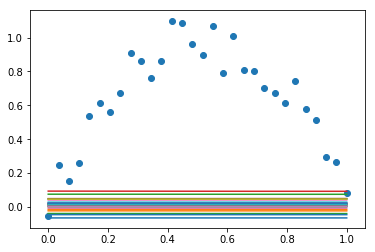

In [183]:
def plot_samples(number):
    for j in range(number):
        lin = np.linspace(0, 1, 100)
        result, _1, _2 = model(torch.from_numpy(lin).reshape(100, 1).type('torch.FloatTensor'))
        result = np.array(result)
        plt.plot(lin, result)
    plt.scatter(x_data, y_data)
    
#plots before learning
plot_samples(32)

In [184]:
#LOSS FUNCTIONS
#this is the one the VAE uses
def lossf(y_real, y_pred, mu, logvar):
    return ELBO(y_real, y_pred, mu, logvar)

def MSE(y_real, y_pred):
    mse = 0
    for i in range(len(y_pred)):
        mse += (y_real[i] - y_pred[i])**2
    return mse/len(y_pred)

def ELBO(newx, x, mu, logvar):
    mse = MSE(newx, x)
    KLD = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse + KLD

def train(epochs, x_data, y_data):
    model.train()
    y_data = torch.from_numpy(y_data).type('torch.FloatTensor').reshape(num_datapoints, 1)
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(torch.from_numpy(x_data).type('torch.FloatTensor').reshape(num_datapoints, 1))
        loss = lossf(y_data, y_pred[0], y_pred[1], y_pred[2])
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print('EPOCH: {} LOSS {}'.format(epoch, loss))
        if epoch % 500 == 0:
            plot_samples(32)
            plt.show()
            
    print('EPOCH: {} LOSS {}'.format(epoch, loss))
    plot_samples(32)
    plt.show()

EPOCH: 0 LOSS tensor([1.1950], grad_fn=<AddBackward0>)


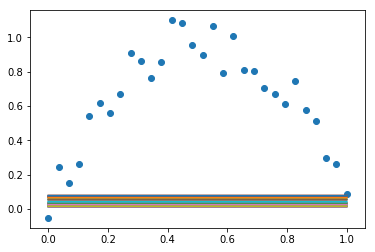

EPOCH: 100 LOSS tensor([0.1040], grad_fn=<AddBackward0>)
EPOCH: 200 LOSS tensor([0.0942], grad_fn=<AddBackward0>)
EPOCH: 300 LOSS tensor([0.0959], grad_fn=<AddBackward0>)
EPOCH: 400 LOSS tensor([0.0932], grad_fn=<AddBackward0>)
EPOCH: 500 LOSS tensor([0.0921], grad_fn=<AddBackward0>)


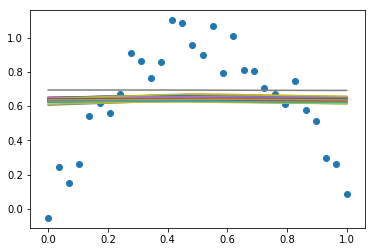

EPOCH: 600 LOSS tensor([0.0439], grad_fn=<AddBackward0>)
EPOCH: 700 LOSS tensor([0.1065], grad_fn=<AddBackward0>)
EPOCH: 800 LOSS tensor([0.1296], grad_fn=<AddBackward0>)
EPOCH: 900 LOSS tensor([0.0171], grad_fn=<AddBackward0>)
EPOCH: 1000 LOSS tensor([0.0101], grad_fn=<AddBackward0>)


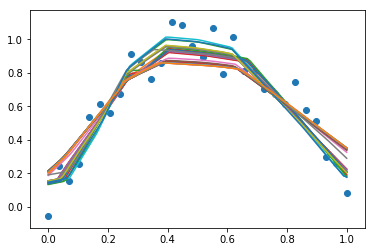

EPOCH: 1100 LOSS tensor([0.0103], grad_fn=<AddBackward0>)
EPOCH: 1200 LOSS tensor([0.0081], grad_fn=<AddBackward0>)
EPOCH: 1300 LOSS tensor([0.0075], grad_fn=<AddBackward0>)
EPOCH: 1400 LOSS tensor([0.0082], grad_fn=<AddBackward0>)
EPOCH: 1500 LOSS tensor([0.0085], grad_fn=<AddBackward0>)


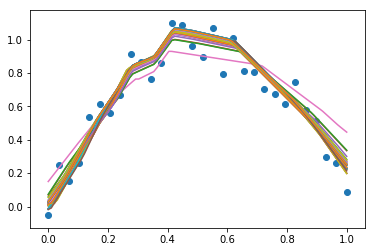

EPOCH: 1600 LOSS tensor([0.0070], grad_fn=<AddBackward0>)
EPOCH: 1700 LOSS tensor([0.0067], grad_fn=<AddBackward0>)
EPOCH: 1800 LOSS tensor([0.0058], grad_fn=<AddBackward0>)
EPOCH: 1900 LOSS tensor([0.0064], grad_fn=<AddBackward0>)
EPOCH: 2000 LOSS tensor([0.0077], grad_fn=<AddBackward0>)


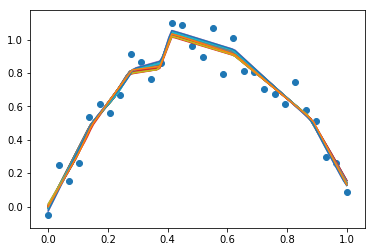

EPOCH: 2100 LOSS tensor([0.0063], grad_fn=<AddBackward0>)
EPOCH: 2200 LOSS tensor([0.0063], grad_fn=<AddBackward0>)
EPOCH: 2300 LOSS tensor([0.0069], grad_fn=<AddBackward0>)
EPOCH: 2400 LOSS tensor([0.0076], grad_fn=<AddBackward0>)
EPOCH: 2500 LOSS tensor([0.0056], grad_fn=<AddBackward0>)


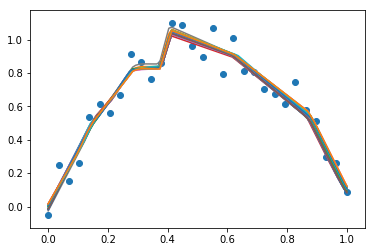

EPOCH: 2600 LOSS tensor([0.0052], grad_fn=<AddBackward0>)
EPOCH: 2700 LOSS tensor([0.0055], grad_fn=<AddBackward0>)
EPOCH: 2800 LOSS tensor([0.0054], grad_fn=<AddBackward0>)
EPOCH: 2900 LOSS tensor([0.0052], grad_fn=<AddBackward0>)
EPOCH: 3000 LOSS tensor([0.0053], grad_fn=<AddBackward0>)


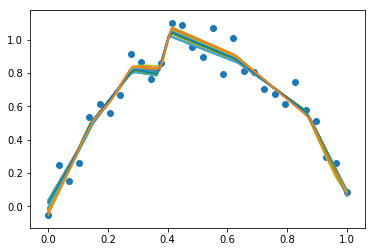

EPOCH: 3100 LOSS tensor([0.0052], grad_fn=<AddBackward0>)
EPOCH: 3200 LOSS tensor([0.0051], grad_fn=<AddBackward0>)
EPOCH: 3300 LOSS tensor([0.0051], grad_fn=<AddBackward0>)
EPOCH: 3400 LOSS tensor([0.0051], grad_fn=<AddBackward0>)
EPOCH: 3500 LOSS tensor([0.0049], grad_fn=<AddBackward0>)


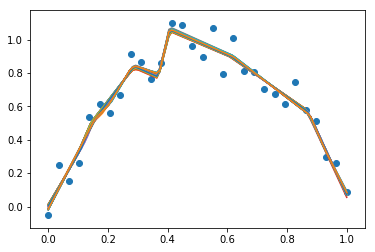

EPOCH: 3600 LOSS tensor([0.0051], grad_fn=<AddBackward0>)
EPOCH: 3700 LOSS tensor([0.0050], grad_fn=<AddBackward0>)
EPOCH: 3800 LOSS tensor([0.0051], grad_fn=<AddBackward0>)
EPOCH: 3900 LOSS tensor([0.0050], grad_fn=<AddBackward0>)
EPOCH: 4000 LOSS tensor([0.0047], grad_fn=<AddBackward0>)


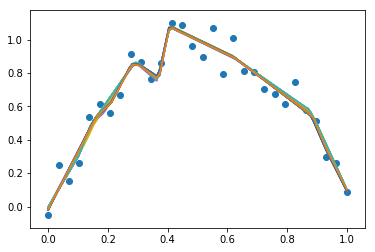

EPOCH: 4100 LOSS tensor([0.0074], grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [185]:
train(5000, x_data, y_data)